Diagnoses use ICD9 - can cluster them into the chapters: https://en.wikipedia.org/wiki/List_of_ICD-9_codes

We already have:
- number of medications
- We have discharge dest and if they were admitted as an emergency


Initial thoughts:

- From the data, those with more medical history - more hospital visits, etc., more medications, 
- discharged to home also was less on non-readdmissions - but discharged to home /w some health service etc. was higher - aligns with people with more medical needs not doing welll after they leave hospital
- also those with "change" in medication see higher rates of readmission
- those with diabetes meds see higher rates of readmission

The story is, those with complex health needs, (made easier to get meds wrong if they've changed), are more likely to see readmission

NEED TO LOOK AT CHARLSON
https://github.com/samisaf/Calculating-Charlson-comorbidity-index-based-on-ICD9-codes/blob/master/input/CharlsonRules3.csv


Methods:
- correlation matrix on the inputs
- pairgrid on the inputs
- think about ROC and AUC
    - what is the best threshold? Does this matter for this problem? (probably, as we want to predict if specific patients would be readmitted)
- R2 - what degree of variation in the data do the models explain?
- for the complex model - the SHAP / LIME for explanability

In [2]:
import pandas as pd
import seaborn as sns
import src.utils as utils

recalculate = False

In [3]:
if recalculate:
    file_path = "data/Diabetes.xlsx"

    # Load the Excel file into a pandas dataframe
    df = pd.read_excel(file_path)
    df['age_interval'] = df['age'].apply(utils.interval_type)
    df['age_factor'] = df['age_interval'].apply(utils.charlson_factor_age)
    df['diag_1_factor'] = df['diag_1'].apply(utils.charlson_factor_icd9)
    df['diag_2_factor'] = df['diag_2'].apply(utils.charlson_factor_icd9)
    df['diag_3_factor'] = df['diag_3'].apply(utils.charlson_factor_icd9)
    df['charlson_comorb_index'] = df.apply(lambda x: utils.charlson_comorb_index([x['diag_1'],x['diag_2'],x['diag_3']], x['age_interval']), axis=1)
    df.to_csv("data/Diabetes_Charlson.csv", index=False)
else:	
    df = pd.read_csv("data/Diabetes_Charlson.csv")

In [4]:
def discharged_home(discharge_disposition: str) -> str:
    """True if the patient was discharged to home, false otherwise"""
    return discharge_disposition == 'Discharged to home'

df['discharged_home'] = discharged_home(df['discharge_disposition_id'])

In [5]:
df.columns

Index(['race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'diag_1_desc', 'diag_2_desc', 'diag_3_desc', 'age_interval',
       'age_factor', 'diag_1_factor', 'diag_2_factor', 

In [6]:
features = ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharged_home', 
            'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
            'num_medications','number_outpatient', 'number_emergency', 'number_inpatient', 
            'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 
            'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 
            'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
            'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide.metformin',
            'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 
            'metformin.pioglitazone', 'change', 'diabetesMed', 'charlson_comorb_index']

target = df['readmitted']*1

numeric_features = df[features].select_dtypes(include='number').columns
categorical_features = list(set(df[features].columns) - set(numeric_features))

categorical_onehot = pd.get_dummies(df[categorical_features], drop_first=True)

df_onehot = pd.concat([df[numeric_features], categorical_onehot*1], axis=1)

In [29]:
onehot_corr = pd.concat([df_onehot, target],axis=1).corr()#.sort_values('readmitted', ascending=False)

for column in onehot_corr.columns:
    print(column, ": ", onehot_corr[column].drop(column).sort_values(ascending=False).head(5))
    print("")

time_in_hospital :  num_medications          0.475244
num_lab_procedures       0.291957
number_diagnoses         0.258570
num_procedures           0.201540
charlson_comorb_index    0.130107
Name: time_in_hospital, dtype: float64

num_lab_procedures :  time_in_hospital                      0.291957
admission_type_id_Emergency           0.248184
admission_source_id_Emergency Room    0.246371
num_medications                       0.236220
A1Cresult_>8                          0.185432
Name: num_lab_procedures, dtype: float64

num_procedures :  num_medications                                 0.424500
time_in_hospital                                0.201540
admission_source_id_Physician Referral          0.145320
admission_source_id_Transfer from a hospital    0.140313
number_diagnoses                                0.100543
Name: num_procedures, dtype: float64

num_medications :  time_in_hospital      0.475244
num_procedures        0.424500
number_diagnoses      0.251479
num_lab_procedures

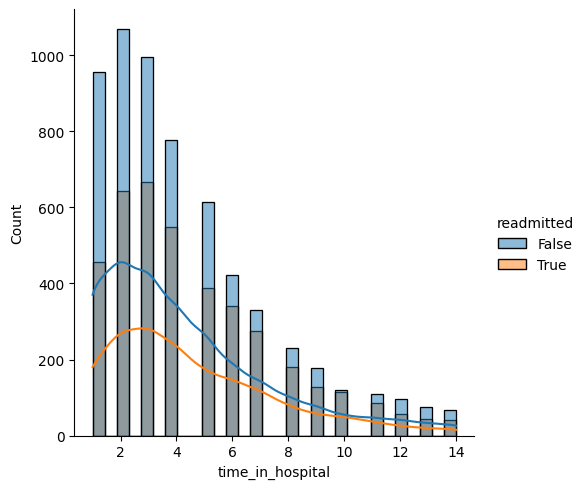

In [8]:
# make histogram of age variable split by readmitted
sns.displot(df, x='time_in_hospital', bins=30, kde=True,hue='readmitted')

In [ ]:
#sns.heatmap(df[df.columns[df.dtypes != 'object']], annot=True, fmt=".2f", cmap="coolwarm")

In [ ]:
for int64_column in df.columns[df.dtypes == 'int64']:
    #print(int64_column)
    sns.displot(df, x=int64_column,hue='readmitted', stat='proportion', multiple='dodge')
    group_readmitted = df.loc[:,[int64_column,'readmitted']].groupby('readmitted')
    print(group_readmitted.describe())


In [ ]:
def group_and_value_count_by_readmitted(df,column):
    """Returns a dataframe with the count of each value in the specified column grouped by readmitted"""
    
    group_readmitted = df.loc[:,[column,'readmitted']].groupby('readmitted')

    return pd.concat([group_readmitted.value_counts(normalize=True),
               group_readmitted.value_counts()
               ],axis=1)

for cat_column in df.drop('readmitted',axis=1).columns:#[df.dtypes == 'object']:
    print(cat_column)
    print(group_and_value_count_by_readmitted(df,cat_column))

    

In [16]:
g = sns.PairGrid(df, 
                 #hue='readmitted', 
                 vars=df.columns[df.dtypes != 'object'][0:4])
g.map(sns.kdeplot)

# thoughts
- So - this ISNT an imbalanced dataset - so don't need to worry about that

In [57]:
import sklearn

# use a tree model to predict readmission
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc

# import random forest classifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

from sklearn.model_selection import train_test_split


# one-hot encode the categorical variables
#f_onehot = pd.get_dummies(df.drop('readmitted',axis=1), drop_first=True)

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_onehot, 
                                                    target, test_size=0.30, 
                                                    random_state=101, stratify=df['readmitted'])

# create a decision tree classifier instance
model = LogisticRegression(penalty=None, max_iter=300)#GradientBoostingClassifier(n_estimators=100, max_depth=4)

# fit the decision tree classifier
model.fit(X_train,y_train)

train_predictions_proba = model.predict_proba(X_train)[:,1]

# use the classifier to predict
predictions_proba = model.predict_proba(X_test)[:,1] # select only positive class

optimun_threshold = 0.5
predictions  = (predictions_proba > optimun_threshold)*1
train_predictions  = (train_predictions_proba > optimun_threshold)*1


# import the metrics class
from sklearn import metrics
from sklearn.metrics import r2_score


tpr, fpr, thresholds = metrics.roc_curve(y_train,train_predictions_proba)
roc_auc = auc(tpr, fpr)

r2_score_value = r2_score(y_test, predictions)
print("R2 Score:", r2_score_value)
r2_score_value = r2_score(y_train, train_predictions)
print("Train R2 Score:", r2_score_value)


# show the confusion matrix

print("roc_auc: ", roc_auc)
print(metrics.confusion_matrix(y_test,predictions))
print(metrics.classification_report(y_train,train_predictions))

# show the accuracy, precision, and recall
print(metrics.classification_report(y_test,predictions))

R2 Score: -0.43599981429035695
Train R2 Score: -0.45261474492243736
roc_auc:  0.6776326243403168
[[1576  234]
 [ 797  393]]
              precision    recall  f1-score   support

           0       0.66      0.86      0.75      4225
           1       0.61      0.33      0.43      2775

    accuracy                           0.65      7000
   macro avg       0.64      0.60      0.59      7000
weighted avg       0.64      0.65      0.62      7000

              precision    recall  f1-score   support

           0       0.66      0.87      0.75      1810
           1       0.63      0.33      0.43      1190

    accuracy                           0.66      3000
   macro avg       0.65      0.60      0.59      3000
weighted avg       0.65      0.66      0.63      3000



d:\PycharmProjects\readmission\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
# calculate f1 score for each threshold value
# f1 = 2 * (precision * recall) / (precision + recall)
# then you can get the argmax of the f1 score and use this to get the best theshold.

inf

In [62]:
thresholds[fpr.argmax()]

0.0801166327866325

In [46]:
df_train_outputs = pd.concat([pd.Series(y_train, name='y_train'),pd.Series(train_predictions, name="train_predictions")],axis=1)

df_train_outputs.query("y_train == train_predictions")

,y_train,train_predictions
3165,0.0,0.0
1659,0.0,0.0
1237,0.0,0.0
347,0.0,0.0
4967,0.0,0.0
...,...,...
3369,0.0,0.0
4548,1.0,1.0
4825,1.0,1.0
6302,0.0,0.0


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'solver': ['liblinear', 'saga'], # 'newton-cg', 'lbfgs', 'sag', 'saga
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)
